# import etc

In [2]:
# ライブラリのインストール
!pip install pytorch-tabnet
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText
!rm -rf fastText
!pip install category_encoders

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.23 MiB | 44.57 MiB/s, done.
Resolving deltas: 100% (2416/2416), done.
     |████████████████████████████████| 71kB 3.5MB/s 
  Created wheel for fastText: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3098242 sha256=ce9d778354a186246c70647230a4a9660bebab1238b94ac74388ec9b88bbd9b7
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fastText
     |████████████████████████████████| 81kB 4.1MB/s 


In [3]:
import os, warnings, re, datetime, random
from typing import Union, List, Optional
from requests import get
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorsys import rgb_to_hsv

from sklearn.preprocessing import LabelEncoder, QuantileTransformer
import category_encoders as ce
from sklearn.metrics import mean_squared_error

from fasttext import load_model
from gensim.models import word2vec
import hashlib

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor

tqdm.pandas()
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 300)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# 実行前にドライブマウントする
%cd /content/drive/MyDrive/kaggle/atmaCup10/notebook

/content/drive/MyDrive/kaggle/atmaCup10/notebook


In [5]:
# config
NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace('.ipynb', '')
DATA_DIR = '../data' # csvを保存してあるディレクトリ
TARGET_COL = 'likes'
SEED = 0
FOLD = 5

In [6]:
train_raw = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_raw = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
df_raw = pd.concat([train_raw, test_raw], ignore_index=True)

# Preprocess&FeatureEngineering

[初心者講座#2](https://www.guruguru.science/competitions/16/discussions/95b7f8ec-a741-444f-933a-94c33b9e66be/)で紹介されているBlockによる特徴作成をベースにしています。

In [7]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError

In [8]:
def left_join(left, right, on='object_id'):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

## メタ情報

### `object_id`と`name`からなるメタ情報

上記の2列のみからなる以下の各ファイルです。
- hirstorical_person.csv
- material.csv
- object_collection.csv
- technique.csv
- production_place.csv

これらは[Word2Vecによる特徴量化](https://www.guruguru.science/competitions/16/discussions/2fafef06-5a26-4d33-b535-a94cc9549ac4/)を行います。その際、これらのファイル以外の情報（例えば、train.csvやtest.csvの`dating_period`情報など）も一緒に文章の一部と見立ててWord2Vecで処理できる様に、同じ形式のpd.DataFrameを用意しておきます。

#### `object_id` + `name`形式のpd.DataFrameの用意

In [9]:
# 読み込むだけ
historical_person = pd.read_csv(os.path.join(DATA_DIR, 'historical_person.csv'))
material = pd.read_csv(os.path.join(DATA_DIR, 'material.csv'))
object_collection = pd.read_csv(os.path.join(DATA_DIR, 'object_collection.csv'))
technique = pd.read_csv(os.path.join(DATA_DIR, 'technique.csv'))
production_place = pd.read_csv(os.path.join(DATA_DIR, 'production_place.csv'))

# principal_makerから作成
principal_maker = pd.read_csv(os.path.join(DATA_DIR, 'principal_maker.csv'))
principal_maker_occupation = pd.read_csv(os.path.join(DATA_DIR, 'principal_maker_occupation.csv'))
makers = principal_maker[['object_id', 'maker_name']].rename(columns={'maker_name': 'name'})
occupation = principal_maker.merge(principal_maker_occupation, on='id', how='left')[['object_id', 'name']].dropna().reset_index(drop=True)
qualification = principal_maker[['object_id', 'qualification']].rename(columns={'qualification': 'name'}).dropna().reset_index(drop=True)

# df_rawから作成
def get_object_name_df(col):
    return df_raw[['object_id', col]].rename(columns={col: 'name'})

acquisition_method = get_object_name_df('acquisition_method')
period = get_object_name_df('dating_period')

#### Block（分散表現を取得）

In [10]:
# https://www.guruguru.science/competitions/16/discussions/4a6f5f84-8491-4324-ba69-dec49dc648cd/
os.environ["PYTHONHASHSEED"] = "0"

def hashfxn(x):
    return int(hashlib.md5(str(x).encode()).hexdigest(), 16)

In [11]:
class ToVecBlock(BaseBlock):
    """word2vecでベクトル化する
    Args:
        df_dict(dict): 複数DataFrameを辞書にしておくとconcatして処理
        window(int): 学習時のwindowサイズ

    """
    def __init__(self, df_dict, window=1):
        self.df_dict = df_dict
        self.window = window
    
    def fit(self, input_df, y=None):
        df = pd.concat([self.df_dict[key] for key in self.df_dict], axis=0).reset_index(drop=True)
        df['name'] = df['name'].astype(str)
        
        model_size = min(50, df['name'].nunique() // 4)
        df_group = df.groupby("object_id")["name"].apply(list).reset_index()

        # Word2Vecの学習
        w2v_model = word2vec.Word2Vec(df_group["name"].values.tolist(),
                                      size=model_size,
                                      min_count=1,
                                      window=self.window,
                                      iter=100,
                                      seed=SEED,
                                      hashfxn=hashfxn)

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = df_group["name"].apply(
            lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        self.sentence_vector_df = pd.DataFrame(sentence_vectors,
                                               columns=[f"{'_'.join(self.df_dict)}_w2v_{self.window}_{i}"
                                                        for i in range(model_size)])
        self.sentence_vector_df.index = df_group["object_id"]
            
        return self.transform(input_df)
    
    def transform(self, input_df):
        return left_join(input_df, self.sentence_vector_df) 

### その他のメタ情報
個別対応

#### color
- paletteがあれば使わなくて良いでしょ、たぶん…

#### palette
- とりあえず色々集計して特徴量化
- hsvに変換した方が明度輝度も出せるので良さそう

In [12]:
%%time
palette = pd.read_csv(os.path.join(DATA_DIR, 'palette.csv'))

# （相対）輝度
# https://note.com/twentynine/n/nd79c8dd275d9
def luminance(r, g, b):
    s = np.array([r, g, b]) / 255
    t = np.where(s < 0.003928, s / 12.92, ((s + 0.055) / 1.055) ** 2.4)
    v = np.array([0.2126, 0.7152, 0.0722])
    output = np.dot(t, v)
    return output

# hueが循環型なのでcos/sin変換を掛ける関数を用意しておく
def encode(input_df, col):
    """cos/sin変換を掛ける関数"""
    output_df = input_df.copy()
    output_df[col + '_cos'] = np.cos(2 * np.pi * output_df[col] / output_df[col].max())
    output_df[col + '_sin'] = np.sin(2 * np.pi * output_df[col] / output_df[col].max())
    return output_df

# （相対）輝度
palette['luminance'] = palette.apply(lambda x: luminance(x['color_r'], x['color_g'], x['color_b']), axis=1)

# HSV
hsv = palette.apply(lambda x: rgb_to_hsv(x['color_r'], x['color_g'], x['color_b']), axis=1).apply(pd.Series)
hsv.columns = ['hue', 'saturation', 'value']

# 結合&cos/sin変換
colors = pd.concat([hsv, palette], axis=1)
colors['hue'] *= 360 # 分かりやすさのためスケールを戻す（0-1で正規化されている）
colors['saturation'] *= 255 # 分かりやすさのためスケールを戻す（0-1で正規化されている）
colors = encode(colors, 'hue')
colors = colors[['object_id', 'ratio', 'color_r', 'color_g', 'color_b', 'hue', 'hue_cos', 'hue_sin', 'saturation', 'value', 'luminance']]

CPU times: user 1min 47s, sys: 2.7 s, total: 1min 49s
Wall time: 1min 49s


In [13]:
class MaxColorsBlock(BaseBlock):
    """ratioが最大のcolors特徴量
    Args:
        colors_df: `object_id`と`ratio`が必須で後は色に関する特徴があるDataFrame
        
    """
    
    def __init__(self, colors_df=colors):
        self.colors_df = colors_df.copy()
        
    def fit(self, input_df):
        max_colors = self.colors_df.groupby('object_id')['ratio'].max().reset_index()
        max_colors = pd.merge(max_colors, self.colors_df, on=['object_id','ratio'], how='left')
        self.max_colors = max_colors.loc[max_colors["object_id"].drop_duplicates().index.tolist()].reset_index(drop=True)
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = left_join(input_df, self.max_colors).add_prefix('max_ratio_')
        return output_df

In [14]:
class MeanColorsBlock(BaseBlock):
    """ratioで加重平均をとったcolors特徴量
    Args:
        colors_df: `object_id`と`ratio`が必須で後は色に関する特徴があるDataFrame

    """
    def __init__(self, colors_df=colors):
        self.colors_df = colors_df.copy()
        
    def fit(self, input_df):
        cols = [c for c in list(colors) if (c != 'object_id')&(c != 'ratio')]
        for c in cols:
            self.colors_df[c] = self.colors_df[c] * self.colors_df['ratio']
        self.mean_colors = self.colors_df.groupby('object_id').sum().reset_index()
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = left_join(input_df, self.mean_colors).add_prefix('weighted_ave_')
        return output_df.drop('weighted_ave_ratio', axis=1)

In [15]:
class StdColorsBlock(BaseBlock):
    """標準偏差
    Args:
        weighted: Trueならratioで加重した上で計算する、Falseならratioを加味しない
        colors_df: `object_id`と`ratio`が必須で後は色に関する特徴があるDataFrame

    """
    def __init__(self, weighted=True, colors_df=colors):
        self.weighted = weighted
        self.colors_df = colors_df.copy()
    
    def transform(self, input_df):
        if self.weighted:
            cols = [c for c in list(colors) if (c != 'object_id')&(c != 'ratio')]
            for c in cols:
                self.colors_df[c] = self.colors_df[c] * self.colors_df['ratio']
        std_colors = self.colors_df.groupby('object_id').std()
        output_df = left_join(input_df, std_colors)
        if self.weighted:
            output_df = output_df.add_prefix('weighted_std_')
        else:
            output_df = output_df.add_prefix('std_')
        return output_df

In [16]:
class RelativeLuminanceBlock(BaseBlock):
    """相対輝度
    Args:
        thres: ratio累計をどこで切って相対輝度を求めるか
        colors_df: `object_id`と`ratio`が必須で後は色に関する特徴があるDataFrame
    Ref:
        https://calculator.jp/science/contrast/
    """
    def __init__(self, thres=0.5, colors_df=colors):
        self.thres = thres
        self.colors_df = colors.copy()
    
    def fit(self, input_df):
        # object_id毎に、輝度昇順に並び替える
        _df = self.colors_df[['object_id', 'ratio', 'luminance']].sort_values(['object_id', 'luminance']).reset_index(drop=True)
        
        # ratioの累計和を取り、thresより大きければ1,小さければ0
        # より明るい方が1、暗い方が0
        _df['ratio_cumsum'] = (_df.groupby('object_id')['ratio'].cumsum() > self.thres).astype(int)
        
        # 平均で良いのかは諸説…加重和の方が良い気もするが果たして
        brighter = _df[_df['ratio_cumsum']==1].groupby(['object_id'])['luminance'].mean() + 0.05
        darker = _df[_df['ratio_cumsum']==0].groupby(['object_id'])['luminance'].mean() + 0.05
        
        _df = (brighter / darker).reset_index()
        _df.columns = ['object_id', 'relative_luminance']
        _df['contrast'] = _df['relative_luminance'].apply(self._contrast)
        self.relative_luminance = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        return left_join(input_df, self.relative_luminance).add_suffix(f"_{self.thres}")
    
    def _contrast(self, x):
        if x < 0.1428:
            return 2
        elif x < 0.222:
            return 1
        elif x < 4.5:
            return 0
        elif x < 7:
            return 1
        else:
            return 2

In [17]:
class SaturationBrightnessBlock(BaseBlock):
    """色味以外、彩度と明度にだけ注目してそれぞれのビニングした値の組み合わせの面積
       色味よりも大事そうな気がする
    Args:
        colors_df: `object_id`と`ratio`が必須で後は色に関する特徴があるDataFrame
    
    """
    def __init__(self, colors_df=colors):
        self.colors_df = colors.copy()
        
    def fit(self, input_df):
        _df = self.colors_df[['object_id', 'ratio', 'saturation', 'value']]
        _df['brightness'] = _df['value'].apply(self._bin_brightness)
        _df['colorfulness'] = _df['saturation'].apply(self._bin_saturation)
        _df = pd.pivot_table(data=_df,
                             values='ratio',
                             index='object_id',
                             columns=['brightness', 'colorfulness'],
                             aggfunc='sum',
                             fill_value=0)
        _df.columns = ["_".join(c) for c in _df.columns]
        self.pivot = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        return left_join(input_df, self.pivot)
    
    # ビニング用、区切り方は四分位数で決めた
    def _bin_brightness(self, x):
        if x < 87:
            return 'dark'
        elif x < 135:
            return 'medium dark'
        elif x < 183:
            return 'medium blight'
        else:
            return 'blight'
    
    def _bin_saturation(self, x):
        if x < 58:
            return 'dull'
        elif x < 86:
            return 'medium dull'
        elif x < 141:
            return 'medium vivid'
        else:
            return 'vivid'

####  principal_maker
maker.csvの情報とくっつけて`object_id`と`principal_maker（maker_name）`でtrain/testとmergeできるようにしておく
- `object_id`-`princpal_maker`の情報が複数行に分かれている場合、ローデータを見て重要そうな情報を残す（手作業修正）
- 使用するmaker.csvの情報は`date_of_death`のみ
    - 年と日が混ざっているので年の情報にしておく
    - あとで`dating_sorting_date`との差を取る。
- その他の情報は意味があると思えなかったためそのまま使わず、NaNの数を特徴量化（仮説：NaNが少ない＝情報が多い＝有名な人＝`likes`が大きい）

In [18]:
maker = pd.read_csv(os.path.join(DATA_DIR, 'maker.csv'))
principal_maker = pd.read_csv(os.path.join(DATA_DIR, 'principal_maker.csv'))

In [19]:
# principal_maker.csvの必要な箇所だけ抜き出し
maker_info = principal_maker[['object_id', 'qualification', 'roles', 'maker_name']].copy().rename(columns={'maker_name': 'principal_maker'})

# [`object_id`, `principal_maker`]の組み合わせが複数あるところを直接修正
# 修正方法はrawデータみてそれらしく
maker_info.loc[2991, 'roles'] = 'print maker'
maker_info.loc[3710, 'roles'] = 'print maker'
maker_info.loc[10484, 'roles'] = 'print maker'

drop_row_idxs = pd.Index([2240, 2427, 2992, 3711, 4952, 7282, 7877, 9121, 10163, 10483,
                 11677, 12675, 14867, 15221, 15610, 16884, 18130, 19754, 20442,
                 20772, 23364])

maker_info = maker_info.drop(drop_row_idxs).reset_index(drop=True)

# maker.csvの情報を結合
maker['maker_null_count'] = maker.isnull().sum(axis=1)
maker['year_of_death'] = maker['date_of_death'].str[:4].astype(float)

maker_info = maker_info.merge(maker[['name', 'maker_null_count', 'year_of_death']],
                             left_on='principal_maker', right_on='name', how='left').drop('name', axis=1)

#### historical_person
OneHotEncodingなどの方法には高カーディナリティ過ぎるので、「何人いたか」と「登場回数の合計」のみを特徴量にする

In [20]:
historical = pd.read_csv(os.path.join(DATA_DIR, 'historical_person.csv'))

In [21]:
class HistoricalFeatureBlock(BaseBlock):
    def __init__(self, historical_df=historical):
        self.historical_df = historical.copy()
        
    def transform(self, input_df):
        self.historical_df['historical_count'] = self.historical_df['name'].map(self.historical_df['name'].value_counts())
        meta_df = self.historical_df.groupby('object_id').agg({
                        'name': 'nunique',
                        'historical_count': 'sum'}).reset_index()
        meta_df.rename(columns={'name': 'historical_nunique'}, inplace=True)
        return left_join(input_df, meta_df)

## Blocks
その他、train.csv / test.csvの情報を処理するBlock

In [22]:
class RawBlock(BaseBlock):
    """input_dfの指定列をそのまま返す"""
    def __init__(self,
                 column: Union[str, List],
                 ):
        self.column = [column] if isinstance(column, str) else column
  
    def transform(self, input_df):
        return input_df[self.column].copy()

In [23]:
class CountEncodingBlock(BaseBlock):
    """For CountEncoding"""
    def __init__(self,
                 column: Union[str, List],
                 whole_df: pd.DataFrame = None,
                 handle_unknown: Optional[Union[int, str]] = None,
                 handle_missing: str = 'count',
                 min_group_size: Optional[int] = None,):
        """
        Args:
            column(str,list): encode column(s)
            whole_df(DataFrame): 入力するとwhole_dfにfit.Noneのままならtrainにfit.
            handle_unknown(str,int): fit時に無かった値がtransformで出てきたらどうするか
                                    None: default.nanに変換する
                                    'error': raise ValueError
                                    'return_nan': nanに変換する
                                    int: 入力値に変換する
            handle_missing(str): nanをどう変換するか
                                'count': default.一つのカテゴリとして変換する
                                'error': raise ValueError
                                'return_nan': nanに変換する
            min_group_size(int): 入力数以下のカウントとなるカテゴリはまとめてカウントする
        reference:
            https://contrib.scikit-learn.org/category_encoders/count.html

        """
        self.column = column
        self.whole_df = whole_df
        self.handle_unknown = handle_unknown
        self.handle_missing = handle_missing
        self.min_group_size = min_group_size
        self.encoder = None
        
    def fit(self, input_df):
        self.encoder = ce.CountEncoder(cols=self.column,
                                       handle_unknown=self.handle_unknown,
                                       handle_missing=self.handle_missing,
                                       min_group_size=self.min_group_size
                                       )
        if self.whole_df is None:
            self.encoder.fit(input_df[self.column])
        else:
            self.encoder.fit(self.whole_df[self.column])
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = self.encoder.transform(input_df[self.column]).add_prefix('CE_')
        return output_df

In [24]:
class TargetEncodingBlock(BaseBlock):
    """For TargetMeanEncoding with CV"""
    def __init__(self,
                 column: Union[str, List],
                 target: str,
                 cv: List,
                 handle_missing: str = 'return_nan',
                 smoothing: float = 1.0,
                 min_samples_leaf:int = 1):
        """
        Args:
            column(str/list): encode column(s)
            target(str): target
            cv(list): cross validation split
            handle_missing(str): nanをどう変換するか
                                 'value': ひとつのカテゴリとしてエンコード対象に加える
                                 'error': raise ValueError. nanが無かった場合はreturn_nanと同様の処理
                                 'return_nan': default.エンコード対象から除外する
            smoothing(float): smoothingの強さ.overfitを避けるため出現数が少ないカテゴリは全体の平均に近づける.
                              ざっくり説明: どんなに大きくしてもそのカテゴリの平均と全体の平均の中間地点で落ち着く.
            min_samples_leaf(int): こちらもsmoothingの強さ.ざっくり説明: 大きいと全体平均に一気に近づく.
        NOTE:
            smoothingの影響をほぼゼロにしたければ、smoothing=1にしてmin_samples_leafを-np.infにすれば良い
         
        """
        self.column = [column] if isinstance(column, str) else column
        self.target = target
        self.cv = cv
        self.handle_missing = handle_missing
        self.smoothing = smoothing
        self.min_samples_leaf = min_samples_leaf
        self.train_df = None
        
    def fit(self, input_df):
        self.train_df = input_df.copy()
        output_df = pd.DataFrame()
        for c in self.column:
            tmp = np.repeat(np.nan, input_df.shape[0])
            for idx_1, idx_2 in self.cv:
                mapping = self._get_mapping(input_df.iloc[idx_1], c)
                if self.handle_missing == 'value':
                    tmp[idx_2] = input_df[c].fillna('NaN').iloc[idx_2].map(mapping)
                else:
                    tmp[idx_2] = input_df[c].iloc[idx_2].map(mapping)
            output_df[f'TE_{c}_{self.target}'] = tmp
        return output_df
    
    def transform(self, input_df):
        output_df = pd.DataFrame()
        for c in self.column:
            mapping = self._get_mapping(self.train_df, c)
            if self.handle_missing == 'value':
                output_df[f'TE_{c}_{self.target}'] = input_df[c].fillna('NaN').map(mapping)
            else:
                output_df[f'TE_{c}_{self.target}'] = input_df[c].map(mapping)
        return output_df
        
    def _get_mapping(self, input_df, col):
        if self.handle_missing == 'value':
            _df = pd.DataFrame({col: input_df[col].fillna('NaN'), 'target': input_df[self.target]})
        elif self.handle_missing == 'return_nan':
            _df = pd.DataFrame({col: input_df[col], 'target': input_df[self.target]})
        else:
            if input_df[self.column].isnull().any().any():
                raise ValueError('Columns to be encoded can not contain null')
            else:
                _df = pd.DataFrame({col: input_df[col], 'target': input_df[self.target]})
            
        prior = _df['target'].mean()
        stats = _df['target'].groupby(_df[col]).agg(['count', 'mean'])
        smoove = 1 / (1 + np.exp(-(stats['count'] - self.min_samples_leaf) / self.smoothing))
        mapping = prior * (1 - smoove) + stats['mean'] * smoove

        return mapping

In [25]:
class PortfolioBlock(BaseBlock):
    """レコード or 特徴量間で集計した数値の比率を特徴量化する"""
    def __init__(self,
                 column: Union[str, List],
                 key: Union[str, List],
                 axis: int=1):
        """
        Args:
            column(str/list): 割合を求めたい列
            key(str/list): 集計するための列
            axis(int): [0, 1]を入力
                1:横方向に集計（key毎に正規化）
                    複数の数値列に対して、keyで集計した時の各列の割合.
                    columnが1つしかない場合はすべて1.0になってしまうのでError.
                0:縦方向に集計（column毎に正規化）
                    1つの数値列に対して、keyで集計した時のkeyの値別の割合.
        """
        self.column = [column] if isinstance(column, str) else column
        self.key = [key] if isinstance(key, str) else key
        self.axis = axis
        self.meta_df = None
        
        if (len(self.column)==1)&(self.axis==1):
            raise ValueError(
                'When `axis` is 1, the number of elements in `column` must be greater than 1.'
            )
    
    def fit(self, input_df):
        _df = input_df.groupby(self.key)[self.column].sum()
        
        if self.axis:
            _df = (_df.T / _df.sum(axis=1)).T
            
        else:
            _df = (_df / _df.sum(axis=0))
            
        self.meta_df = _df.reset_index()
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = pd.merge(input_df[self.key], self.meta_df,
                          on=self.key, how='left').drop(columns=self.key)
        output_df = output_df.add_prefix(f'PF@{"+".join(self.key)}_')
        return output_df

言語判定

https://www.guruguru.science/competitions/16/discussions/f463dac2-4233-42d2-8629-ca99a9689987/

In [26]:
class LangBlock(BaseBlock):
    def __init__(self, column):
        self.column = column
        self.model = load_model(os.path.join(DATA_DIR,'lid.176.bin'))

    def transform(self, input_df):
        output_df = pd.DataFrame()
        output_df[f'{self.column}_lang'] = input_df[self.column].fillna('').map(
            lambda x: self.model.predict(x.replace('\n', ''))[0][0])
        output_df[f'{self.column}_lang'] = output_df[f'{self.column}_lang'].str.replace('__label__', '')
        return output_df

サイズ

https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

In [27]:
class SizeBlock(BaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame()
        for axis in ['h', 'w', 't', 'd']:
            column_name = f'size_{axis}'
            size_info = input_df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
            size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
            size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
            size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
            output_df[column_name] = size_info[column_name] # input_dfにくっつける
        output_df['size'] = output_df['size_h'] * output_df['size_w']
        return output_df

テキストの長さ

https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/

In [28]:
class StringLength(BaseBlock):
    def __init__(self, column):
        self.column = [column] if isinstance(column, str) else column
    
    def transform(self, input_df):
        output_df = pd.DataFrame()
        
        for c in self.column:
            output_df[c] = input_df[c].str.len()
        
        return output_df.add_prefix('StringLength_')

# Process

In [29]:
from contextlib import contextmanager
from time import time
from tqdm import tqdm

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)
        
def get_function(block, is_train):
    s = mapping = {
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block, s)

def to_feature(input_df, blocks, is_train=False):
    """
    DataFrameからblocksの処理により新しい特徴量を作る（input_dfとは別物をReturn）
	
    """
    output_df = pd.DataFrame()
    
    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)
        
        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)
            
        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)
        
    return output_df

## merge
ここで[BERT特徴](https://www.guruguru.science/competitions/16/discussions/fb792c87-6bad-445d-aa34-b4118fc378c1/)を結合していましたが別のnotebookでcsvにしたのを読み込んでいたのでここでは省略しています。

In [30]:
def merge_and_simple_fe(input_df):
    output_df = input_df.copy()
    # ============================================================
    # merge
    # ============================================================
    # maker_info
    output_df = output_df.merge(maker_info, on=['object_id', 'principal_maker'], how='left')
    
    # ============================================================
    # simple_fe
    # ============================================================
    # 製作期間
    output_df['production_period'] = output_df['dating_year_late'] - output_df['dating_year_early']

    # 没年と製作年の差
    output_df['late_to_death'] = output_df['year_of_death'] - input_df['dating_year_late']

    # acquisition_dateを年数のみ、floatに
    output_df['acquisition_date'] = output_df['acquisition_date'].str[:4].astype(float)

    return output_df

In [31]:
df_merged = merge_and_simple_fe(df_raw)
train_merged = df_merged[:len(train_raw)].reset_index(drop=True)
test_merged = df_merged[len(train_raw):].reset_index(drop=True)

In [32]:
assert len(test_merged) == len(test_raw)

## Process①データフレームの作成

In [33]:
raw_cols = df_merged.drop('likes', axis=1).select_dtypes('number').columns # 数値変数
raw_cats = ['acquisition_method', 'copyright_holder'] # Embedding処理する
sl_cols = ['description', 'more_title', 'sub_title', 'title', 'long_title'] # StringLengthBlock
ce_cols = ['art_series_id', 'acquisition_credit_line', 'dating_presenting_date']
te_cols = ['acquisition_method', 'dating_period'] # TargetEncoding
pf_keys = ['dating_period', 'dating_sorting_date'] # Portfolio
vec_df_dict = [{'material': material,
            'object': object_collection,
            'tech': technique,
            'makers': makers,
            'place': production_place,
            'acquisition': acquisition_method,
            'period': period,
            'occupation': occupation,
            'qualification': qualification},
            {'material': material},
            {'object': object_collection},
            {'tech': technique},
            {'makers': makers},
            {'place': production_place},
            {'makers': makers,
             'occupation': occupation,
             'qualification': qualification},
            {'material': material,
             'object': object_collection,
             'tech': technique,
             'place': production_place,
             'period': period,
            }]

In [34]:
from sklearn.model_selection import StratifiedKFold

num_bins = np.int(1 + np.log2(len(train_raw)))
bins = pd.cut(train_raw[TARGET_COL],
                bins = num_bins,
                labels=False
                )
skf = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=SEED)
cv = list(skf.split(X=train_raw, y=bins.values))

In [35]:
blocks = [
    RawBlock(raw_cols),
    RawBlock(raw_cats),
    CountEncodingBlock(ce_cols, df_merged),
    StringLength(sl_cols),
    SizeBlock(),
    TargetEncodingBlock(te_cols, TARGET_COL, cv),
    *[PortfolioBlock(TARGET_COL, c, axis=0) for c in pf_keys],
    *[ToVecBlock(d, w) for d in vec_df_dict for w in range(1, 5)],
    MaxColorsBlock(),
    MeanColorsBlock(),
    StdColorsBlock(weighted=True),
    StdColorsBlock(weighted=False),
    RelativeLuminanceBlock(thres=0.5),
    RelativeLuminanceBlock(thres=0.25),
    RelativeLuminanceBlock(thres=0.75),
    SaturationBrightnessBlock(),
    HistoricalFeatureBlock(),
    LangBlock('title')
]

In [36]:
train = to_feature(train_merged, blocks, is_train=True)
test = to_feature(test_merged, blocks)

  0%|          | 0/50 [00:00<?, ?it/s]

create <__main__.RawBlock object at 0x7fa7c7a80690> 0.007[s]
create <__main__.RawBlock object at 0x7fa7c7a80650> 0.001[s]
create <__main__.CountEncodingBlock object at 0x7fa7c7a806d0> 0.031[s]
create <__main__.StringLength object at 0x7fa7c7a80750> 0.022[s]


 16%|█▌        | 8/50 [00:00<00:03, 10.82it/s]

create <__main__.SizeBlock object at 0x7fa7c7a80790> 0.513[s]
create <__main__.TargetEncodingBlock object at 0x7fa7c7a807d0> 0.079[s]
create <__main__.PortfolioBlock object at 0x7fa7c7a80850> 0.006[s]
create <__main__.PortfolioBlock object at 0x7fa7c7a80890> 0.008[s]
create <__main__.ToVecBlock object at 0x7fa7c7a808d0> 9.155[s]


 20%|██        | 10/50 [00:19<01:54,  2.85s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80910> 9.404[s]


 22%|██▏       | 11/50 [00:28<03:10,  4.89s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80950> 9.656[s]


 24%|██▍       | 12/50 [00:38<04:00,  6.34s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80990> 9.686[s]


 26%|██▌       | 13/50 [00:41<03:18,  5.37s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a809d0> 3.103[s]


 28%|██▊       | 14/50 [00:44<02:49,  4.70s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80a50> 3.133[s]


 30%|███       | 15/50 [00:48<02:29,  4.27s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80a90> 3.245[s]


 32%|███▏      | 16/50 [00:51<02:13,  3.93s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80ad0> 3.108[s]


 34%|███▍      | 17/50 [00:53<01:48,  3.29s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80b10> 1.773[s]


 36%|███▌      | 18/50 [00:54<01:30,  2.83s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80a10> 1.762[s]


 38%|███▊      | 19/50 [00:56<01:18,  2.52s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80b50> 1.763[s]


 40%|████      | 20/50 [00:58<01:08,  2.30s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80b90> 1.768[s]


 42%|████▏     | 21/50 [01:00<01:06,  2.28s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80bd0> 2.228[s]


 44%|████▍     | 22/50 [01:02<01:03,  2.27s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80c10> 2.221[s]


 46%|████▌     | 23/50 [01:05<01:01,  2.27s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80c50> 2.246[s]


 48%|████▊     | 24/50 [01:07<00:59,  2.27s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80c90> 2.264[s]


 50%|█████     | 25/50 [01:12<01:14,  2.98s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80cd0> 4.615[s]


 52%|█████▏    | 26/50 [01:16<01:23,  3.50s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80d10> 4.689[s]


 54%|█████▍    | 27/50 [01:21<01:29,  3.88s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80d50> 4.756[s]


 56%|█████▌    | 28/50 [01:26<01:31,  4.15s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80d90> 4.738[s]


 58%|█████▊    | 29/50 [01:28<01:14,  3.57s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80dd0> 2.203[s]


 60%|██████    | 30/50 [01:30<01:03,  3.16s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80e10> 2.181[s]


 62%|██████▏   | 31/50 [01:32<00:54,  2.86s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80e50> 2.142[s]


 64%|██████▍   | 32/50 [01:35<00:48,  2.71s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80e90> 2.318[s]


 66%|██████▌   | 33/50 [01:40<01:00,  3.55s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80ed0> 5.467[s]


 68%|██████▊   | 34/50 [01:46<01:06,  4.18s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80f10> 5.641[s]


 70%|███████   | 35/50 [01:51<01:08,  4.58s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80f50> 5.476[s]


 72%|███████▏  | 36/50 [01:57<01:08,  4.87s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80f90> 5.522[s]


 74%|███████▍  | 37/50 [02:02<01:05,  5.05s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a80fd0> 5.431[s]


 76%|███████▌  | 38/50 [02:08<01:02,  5.18s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a7a050> 5.454[s]


 78%|███████▊  | 39/50 [02:13<00:58,  5.28s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a7a090> 5.460[s]


 80%|████████  | 40/50 [02:19<00:53,  5.36s/it]

create <__main__.ToVecBlock object at 0x7fa7c7a7a0d0> 5.515[s]


 84%|████████▍ | 42/50 [02:20<00:22,  2.75s/it]

create <__main__.MaxColorsBlock object at 0x7fa7c7a80810> 0.358[s]
create <__main__.MeanColorsBlock object at 0x7fa7ca7e1bd0> 0.122[s]


 88%|████████▊ | 44/50 [02:20<00:08,  1.44s/it]

create <__main__.StdColorsBlock object at 0x7fa7c77fa910> 0.171[s]
create <__main__.StdColorsBlock object at 0x7fa7c77f0750> 0.135[s]


 90%|█████████ | 45/50 [02:20<00:05,  1.13s/it]

create <__main__.RelativeLuminanceBlock object at 0x7fa7c7a55290> 0.401[s]


 92%|█████████▏| 46/50 [02:21<00:03,  1.09it/s]

create <__main__.RelativeLuminanceBlock object at 0x7fa7c7a55e10> 0.395[s]


 94%|█████████▍| 47/50 [02:21<00:02,  1.31it/s]

create <__main__.RelativeLuminanceBlock object at 0x7fa7c7a55590> 0.390[s]


 96%|█████████▌| 48/50 [02:22<00:01,  1.42it/s]

create <__main__.SaturationBrightnessBlock object at 0x7fa7c7a55690> 0.539[s]
create <__main__.HistoricalFeatureBlock object at 0x7fa7c7804ad0> 0.020[s]


  0%|          | 0/50 [00:00<?, ?it/s]

create <__main__.LangBlock object at 0x7fa7c7a7a310> 0.191[s]
create <__main__.RawBlock object at 0x7fa7c7a80690> 0.007[s]
create <__main__.RawBlock object at 0x7fa7c7a80650> 0.001[s]
create <__main__.CountEncodingBlock object at 0x7fa7c7a806d0> 0.010[s]
create <__main__.StringLength object at 0x7fa7c7a80750> 0.024[s]


 24%|██▍       | 12/50 [00:00<00:03, 11.99it/s]

create <__main__.SizeBlock object at 0x7fa7c7a80790> 0.505[s]
create <__main__.TargetEncodingBlock object at 0x7fa7c7a807d0> 0.012[s]
create <__main__.PortfolioBlock object at 0x7fa7c7a80850> 0.004[s]
create <__main__.PortfolioBlock object at 0x7fa7c7a80890> 0.005[s]
create <__main__.ToVecBlock object at 0x7fa7c7a808d0> 0.016[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80910> 0.016[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80950> 0.016[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80990> 0.017[s]
create <__main__.ToVecBlock object at 0x7fa7c7a809d0> 0.012[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80a50> 0.011[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80a90> 0.011[s]


 44%|████▍     | 22/50 [00:00<00:01, 18.84it/s]

create <__main__.ToVecBlock object at 0x7fa7c7a80ad0> 0.013[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80b10> 0.009[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80a10> 0.010[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80b50> 0.010[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80b90> 0.009[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80bd0> 0.009[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80c10> 0.008[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80c50> 0.011[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80c90> 0.009[s]


 52%|█████▏    | 26/50 [00:01<00:01, 21.58it/s]

create <__main__.ToVecBlock object at 0x7fa7c7a80cd0> 0.016[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80d10> 0.016[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80d50> 0.017[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80d90> 0.016[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80dd0> 0.013[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80e10> 0.013[s]


 66%|██████▌   | 33/50 [00:01<00:00, 23.24it/s]

create <__main__.ToVecBlock object at 0x7fa7c7a80e50> 0.014[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80e90> 0.013[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80ed0> 0.016[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80f10> 0.017[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80f50> 0.017[s]


 78%|███████▊  | 39/50 [00:01<00:00, 21.57it/s]

create <__main__.ToVecBlock object at 0x7fa7c7a80f90> 0.016[s]
create <__main__.ToVecBlock object at 0x7fa7c7a80fd0> 0.017[s]
create <__main__.ToVecBlock object at 0x7fa7c7a7a050> 0.016[s]
create <__main__.ToVecBlock object at 0x7fa7c7a7a090> 0.016[s]
create <__main__.ToVecBlock object at 0x7fa7c7a7a0d0> 0.016[s]


 84%|████████▍ | 42/50 [00:01<00:00, 21.66it/s]

create <__main__.MaxColorsBlock object at 0x7fa7c7a80810> 0.013[s]
create <__main__.MeanColorsBlock object at 0x7fa7ca7e1bd0> 0.012[s]


 90%|█████████ | 45/50 [00:02<00:00, 14.82it/s]

create <__main__.StdColorsBlock object at 0x7fa7c77fa910> 0.156[s]
create <__main__.StdColorsBlock object at 0x7fa7c77f0750> 0.131[s]
create <__main__.RelativeLuminanceBlock object at 0x7fa7c7a55290> 0.010[s]


 98%|█████████▊| 49/50 [00:02<00:00, 17.62it/s]

create <__main__.RelativeLuminanceBlock object at 0x7fa7c7a55e10> 0.013[s]
create <__main__.RelativeLuminanceBlock object at 0x7fa7c7a55590> 0.010[s]
create <__main__.SaturationBrightnessBlock object at 0x7fa7c7a55690> 0.011[s]
create <__main__.HistoricalFeatureBlock object at 0x7fa7c7804ad0> 0.016[s]


100%|██████████| 50/50 [00:02<00:00, 20.57it/s]

create <__main__.LangBlock object at 0x7fa7c7a7a310> 0.177[s]


In [37]:
# 他の列と閾値以下の相関を持つ列名を取得する関数
def corr_column(input_df, threshold):
    df_corr = input_df.corr()
    df_corr = abs(df_corr)
    columns = df_corr.columns

    # 対角線の値を0にする
    for i in range(0, len(columns)):
        df_corr.iloc[i, i] = 0

    while True:
        columns = df_corr.columns
        max_corr = 0.0
        query_column = None
        target_column = None

        df_max_column_value = df_corr.max()
        max_corr = df_max_column_value.max()
        query_column = df_max_column_value.idxmax()
        target_column = df_corr[query_column].idxmax()

        if max_corr < threshold:
            # しきい値を超えるものがなかったため終了
            break
        else:
            # しきい値を超えるものがあった場合
            delete_column = None
            saved_column = None

            # その他との相関の絶対値が大きい方を除去
            if sum(df_corr[query_column]) <= sum(df_corr[target_column]):
                delete_column = target_column
                saved_column = query_column
            else:
                delete_column = query_column
                saved_column = target_column

            # 除去すべき特徴を相関行列から消す（行、列）
            df_corr.drop([delete_column], axis=0, inplace=True)
            df_corr.drop([delete_column], axis=1, inplace=True)

    return list(df_corr)

In [38]:
# 閾値以下の相関を持つ列+カテゴリ列を抽出
low_corr_column = corr_column(train, 0.98) + list(train.select_dtypes('object'))

In [94]:
def postprocess(input_df):
    output_df = output_df[low_corr_column].copy()
    # 行ごとにnullの数を特徴量化
    output_df['num_null'] = output_df.isnull().sum(axis=1)
    return output_df

In [95]:
train_postprocessed = postprocess(train)
test_postprocessed = postprocess(test)

In [96]:
assert len(test_postprocessed) == len(test_raw)

# Functions for TabNet

In [97]:
# SEED固定
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(SEED)

In [98]:
# preprocess
def tabnet_preprocess(input_df, n_as_cat):
    """
    Args:
        input_df: train_test
        n_as_cat: unique数がこの数以下のnumericはcategoryとして扱う

    """
    output_df = input_df.copy()
    nunique = output_df.nunique()
    types = output_df.dtypes
    categorical_columns = []
    categorical_dims =  {}

    for i, col in enumerate(output_df.columns):
        if (types[col] == 'object')|(nunique[col] < n_as_cat):
            print(i, col, output_df[col].nunique())
            enc = LabelEncoder()
            output_df[col] = output_df[col].fillna("<missing>").astype('str')
            output_df[col] = enc.fit_transform(output_df[col].values)
            categorical_columns.append(col)
            categorical_dims[col] = output_df[col].nunique()
        else:
            train_indices = train_raw.index
            output_df.fillna(input_df.loc[train_indices, col].mean(), inplace=True)

    return output_df, categorical_columns, categorical_dims

In [99]:
# 学習・予測
def run_tabnet(cv,
               X_train,
               y_train,
               X_test,
               pretrain=True,
               # model params
               n_d=8,
               n_a=8,
               n_steps=3,
               gamma=1.3,
               cat_idxs=[],
               cat_dims=[],
               cat_emb_dim=[],
               n_independent=2,
               n_shared=2,
               seed=0,
               optimizer_fn=torch.optim.Adam,
               optimizer_params=dict(lr=2e-2),
               mask_type='sparsemax',
               lambda_sparse=1e-3,
               scheduler_fn=None,
               scheduler_params=None,
               verbose=10,
               # fit params
               eval_metric=['rmse'],
               loss_fn=None,
               max_epochs=200,
               patience=15,
               batch_size=1024,
               virtual_batch_size=128,
               num_workers=0,
               pretraining_ratio=0.5
               ):
    """
    Args:
        cv(list): バリデーションのリスト
        X_train(np.ndarray): 学習データ
        y_train(np.ndarray): 正解ラベル
        X_test(np.ndarray): 評価データ
        pretrain(bool): 事前学習をするかどうか
        他はpytorch-tabnetのパラメータのうち、変更することがありそうなもの

    """

    oof = np.zeros((len(X_train),))
    test_preds_all = np.zeros((len(X_test),))
    models = []
    pretrainer = None

    if pretrain:
        pretrainer = TabNetPretrainer(
                     n_d=n_d, n_a=n_a,
                     n_steps=n_steps,
                     gamma=gamma,
                     n_independent=n_independent,
                     n_shared=n_shared,
                     seed=seed,
                     lambda_sparse=lambda_sparse, 
                     cat_idxs=cat_idxs,
                     cat_dims=cat_dims,
                     cat_emb_dim=cat_emb_dim,
                     optimizer_fn=optimizer_fn,
                     optimizer_params=optimizer_params,
                     mask_type=mask_type,
                     scheduler_params=scheduler_params,
                     scheduler_fn=scheduler_fn,
                     verbose=verbose)
        print('★'*20, 'START PRETRAINING', '★'*20)
        pretrainer.fit(X_train=X_train,
                       eval_set=[X_train],
                       max_epochs=max_epochs,
                       patience=patience,
                       batch_size=batch_size,
                       virtual_batch_size=virtual_batch_size,
                       num_workers=num_workers,
                       pretraining_ratio=pretraining_ratio)
        print('★'*20, 'FINISH PRETRAINING', '★'*20)

    for fold, (tr_idx, va_idx) in enumerate(cv):
        print()
        print('FOLD: ', fold)

        x_tr, y_tr = X_train[tr_idx], y_train[tr_idx].reshape(-1, 1)
        x_va, y_va = X_train[va_idx], y_train[va_idx].reshape(-1, 1)
        
        model = TabNetRegressor(
                     n_d=n_d, n_a=n_a,
                     n_steps=n_steps,
                     gamma=gamma,
                     n_independent=n_independent,
                     n_shared=n_shared,
                     seed=seed,
                     lambda_sparse=lambda_sparse, 
                     cat_idxs=cat_idxs,
                     cat_dims=cat_dims,
                     cat_emb_dim=cat_emb_dim,
                     optimizer_fn=optimizer_fn,
                     optimizer_params=optimizer_params,
                     mask_type=mask_type,
                     scheduler_params=scheduler_params,
                     scheduler_fn=scheduler_fn,
                     verbose=verbose)
        model.fit(X_train=x_tr,
                  y_train=y_tr,
                  eval_set=[(x_tr, y_tr),(x_va, y_va)],
                  eval_name=['train', 'valid'],
                  eval_metric=eval_metric,
                  loss_fn=loss_fn,
                  max_epochs=max_epochs,
                  patience=patience,
                  batch_size=batch_size,
                  virtual_batch_size=virtual_batch_size,
                  num_workers=num_workers,
                  from_unsupervised=pretrainer)

        models.append(model)
        oof[va_idx] = model.predict(x_va).ravel()
        pred = model.predict(X_test).ravel()
        test_preds_all += pred / len(cv)

    score = mean_squared_error(y_train, oof) ** .5
    print('Whole RMSLE: {:.4f}'.format(score))

    return models, oof, test_preds_all

In [100]:
# 引数次第で正規化（TabNetは不要だがやった方が良いことも）してndarray（X_train, y_train, X_test）を返す
def get_tabnet_dateset(input_df, rankgauss=False, seed=0):
    """
    Args:
        input_df(pd.DataFrame): 前処理後のtrain_test
        rankgauss(bool): Trueだと数値列にrankgaussかける
        seed(int): seed
    Requirements: 以下の変数が外側で定義されていないと動かない
        - train_raw / test_rawという名前のtrainとtestの長さを保ったpd.DataFrame（切り分けに使用）
        - num_colsという名前の数値列名を格納したリスト（rankgaussをかける列の判別に使用）
        - train_rawに含まれるtargetの列名をTARGET_COLとして定義（y_trainの取得に使用）
    """
    if rankgauss:
        transformer = QuantileTransformer(n_quantiles=100, random_state=seed, output_distribution='normal')

        # pytorch-tabnetでカテゴリ変数として扱うもの以外を正規化
        # いったんすべてRankGaussをかけて数値列だけ入れ替える
        df_scaled = pd.DataFrame(transformer.fit_transform(input_df))
        df_scaled.columns = input_df.columns

        for c in list(df_scaled):
            if c not in num_cols:
                df_scaled[c] = input_df[c]

        X_train = df_scaled[:len(train_raw)].reset_index(drop=True).values
        X_test = df_scaled[len(train_raw):].reset_index(drop=True).values
        y_train = train_raw[TARGET_COL].values
         
    else:
        X_train = input_df[:len(train_raw)].reset_index(drop=True).values
        X_test = input_df[len(train_raw):].reset_index(drop=True).values
        y_train = train_raw[TARGET_COL].values

    return X_train, X_test, y_train

In [101]:
# importanceの可視化
def visualize_tabnet_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('TabNet Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

In [102]:
# maskの可視化
def visualize_mask(models_tabnet, feat_train_df):
    masks_list = []
    for model in models_tabnet:
        _, masks = model.explain(X_test)
        masks_list.append(masks)

    masks_dict = {}
    for i in range(len(masks_list[0])):
        masks_dict[i] = np.zeros(masks_list[0][0].shape)

    for masks in masks_list:
        for i in range(len(masks)):
            masks_dict[i] += masks[i] / len(masks_list)

    h = (len(masks_dict) + 2) // 3
    fig, axes = plt.subplots(h, 3, figsize=(20, h*3), sharey=True, sharex='col')

    for i in range(len(masks_dict)):
        if h == 1:
            sns.heatmap(masks_dict[i], cmap='viridis', xticklabels=feat_train_df.columns, ax=axes[i], cbar=False)
            axes[i].set_title(f'mask {i}')
            axes[i].yaxis.set_visible(False)
        else:
            sns.heatmap(masks_dict[i], cmap='viridis', xticklabels=feat_train_df.columns, ax=axes[i//3][i%3], cbar=False)
            axes[i//3][i%3].set_title(f'mask {i}')
            axes[i//3][i%3].yaxis.set_visible(False)

    return fig

In [103]:
# RMSE
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return torch.mean(loss)

# Process② ndarrayの作成

In [104]:
train_test = pd.concat([train_postprocessed, test_postprocessed], ignore_index=True)

In [105]:
df_tabnet, categorical_columns, categorical_dims = tabnet_preprocess(train_test, n_as_cat=10)

5 maker_null_count 7
9 acquisition_method 9
10 copyright_holder 43
1128 contrast_0.5 4
1130 contrast_0.25 4
1132 contrast_0.75 4
1151 title_lang 43


In [106]:
features = [ col for col in df_tabnet.columns if col != TARGET_COL] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
cat_emb_dim = [min(10, (x + 1) // 2) for x in cat_dims]
num_cols = [col for col in features if col not in categorical_columns]

In [107]:
X_train, X_test, y_train = get_tabnet_dateset(df_tabnet, rankgauss=False, seed=SEED)
y_train = np.log1p(y_train)

In [108]:
assert len(X_test) == len(test_raw)

# Training

In [109]:
optimizer_params=dict(lr=2e-2, weight_decay=1e-5)
scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params=dict(mode="min",
                    patience=5,
                    min_lr=1e-5,
                    factor=0.9
                    )

In [110]:
models_tabnet, oof_tabnet, pred_tabnet = run_tabnet(n_steps=5, mask_type='entmax', gamma=0.9,
                                                    cv=cv, X_train=X_train, y_train=y_train, X_test=X_test,
                                                    seed=SEED, pretrain=False,
                                                    cat_idxs=cat_idxs, cat_dims=cat_dims, cat_emb_dim=cat_emb_dim,
                                                    optimizer_params=optimizer_params,
                                                    scheduler_params=scheduler_params, scheduler_fn=scheduler_fn,
                                                    loss_fn=RMSELoss(), patience=50
                                                    )


FOLD:  0
Device used : cuda
epoch 0  | loss: 2.02114 | train_rmse: 2.09624 | valid_rmse: 2.15768 |  0:00:01s
epoch 10 | loss: 1.17024 | train_rmse: 1.58738 | valid_rmse: 1.57984 |  0:00:14s
epoch 20 | loss: 1.12529 | train_rmse: 1.23278 | valid_rmse: 1.24413 |  0:00:27s
epoch 30 | loss: 1.08571 | train_rmse: 1.0876  | valid_rmse: 1.13573 |  0:00:39s
epoch 40 | loss: 1.0702  | train_rmse: 1.04949 | valid_rmse: 1.11985 |  0:00:52s
epoch 50 | loss: 1.04802 | train_rmse: 1.04634 | valid_rmse: 1.13656 |  0:01:05s
epoch 60 | loss: 1.02199 | train_rmse: 1.00831 | valid_rmse: 1.12526 |  0:01:18s
epoch 70 | loss: 0.99077 | train_rmse: 0.96018 | valid_rmse: 1.09527 |  0:01:31s
epoch 80 | loss: 0.97358 | train_rmse: 0.93004 | valid_rmse: 1.09334 |  0:01:44s
epoch 90 | loss: 0.9635  | train_rmse: 0.9188  | valid_rmse: 1.10284 |  0:01:56s
epoch 100| loss: 0.93311 | train_rmse: 0.90701 | valid_rmse: 1.11677 |  0:02:09s
epoch 110| loss: 0.91621 | train_rmse: 0.87929 | valid_rmse: 1.10367 |  0:02:22s

# Loss&Importance

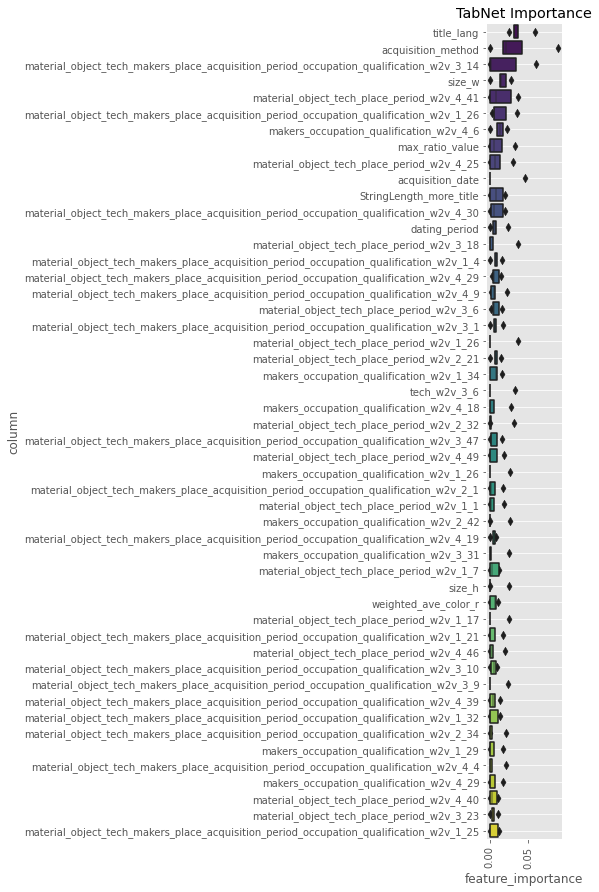

In [111]:
fig_tabnet, _ = visualize_tabnet_importance(models_tabnet, df_tabnet)

In [112]:
# # mask。特徴が多いと意味が分からない
# mask_tabnet = visualize_mask(models_tabnet, df_tabnet)

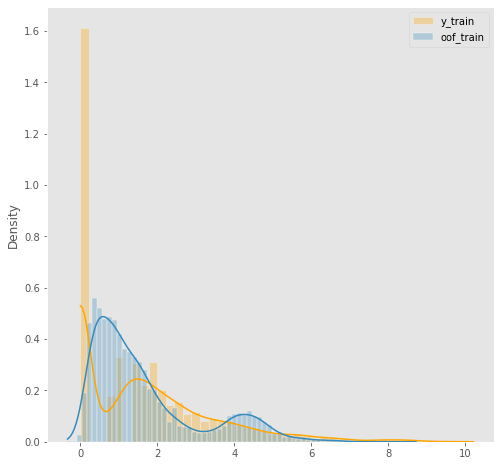

In [113]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(y_train, label='y_train', kde=True ,stat="density", common_norm=False, color='orange', alpha=0.3)
sns.histplot(oof_tabnet, label='oof_train', kde=True, stat="density", common_norm=False, alpha=0.3)
ax.legend()
ax.grid()

# Submission

In [116]:
# oof出力
pd.DataFrame({'oof_tabnet': oof_tabnet}).to_csv(f'../output/{NOTEBOOK_NAME}_oof.csv', index=False)

# submission出力
sub = pd.read_csv(os.path.join(DATA_DIR, 'atmacup10__sample_submission.csv'))
sub['likes'] = np.expm1(pred_tabnet)
sub.loc[sub.likes <= 0,"likes"] = 0
sub.to_csv(f'../output/{NOTEBOOK_NAME}_sub.csv',index=False)